# Recreating Jacob's notebook - refactored

## 1. Imports & Functions

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, read_inventory, Inventory, Stream
from scipy.io import loadmat
from pyproj import CRS, Transformer
import gzip
import xarray as xr
import pygmt

# =========================
# Helpers
# =========================
def read_station_trace(st_code: str, directory: Path, inv: Inventory | None, lc: float = 1.0, hc: float = 99.0, sps: float = 200.0):
    """
    Read and preprocess a single station's HHZ MiniSEED trace.
    Adjust the filename pattern to your real data. Right now it expects:
      <directory>/.12.11.6Q.<STATION>..HHZ.MSEED
    """
    fpath = directory / f"2022.12.11.6Q.{st_code}..HHZ.mseed"
    try:
        st = read(str(fpath))
    except FileNotFoundError:
        print(f"Missing: {fpath}")
        return None

    st.resample(sampling_rate=sps)
    tr = st[0]
    tr.detrend('linear')
    tr.taper(0.05)
    if inv:
        pre_filt = [lc*0.8, lc, hc * 0.8, hc]
        try:
            tr.remove_response(inventory=inv, pre_filt=pre_filt, output='VEL')  # choose VEL/DISP/ACC on purpose
        except Exception as e:
            print(f"remove_response failed for {fpath.name}: {e}")
            return None
    else:
        tr.filter('bandpass', freqmin=lc, freqmax=hc, corners=2)
    return tr

def window_rms(arr: np.ndarray, start_idx: int, end_idx: int) -> float:
    """RMS in [start_idx:end_idx). NaN if invalid."""
    if start_idx < 0 or end_idx > arr.size or start_idx >= end_idx:
        return np.nan
    seg = arr[start_idx:end_idx]
    if np.all(np.isnan(seg)):
        return np.nan
    return np.sqrt(np.nanmean(seg**2))


## 2. Config / constants

In [2]:
DATA_DIR = Path('/Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/Jacob')
MAT_FILE = DATA_DIR / "outputfromReadMapData.mat"
XML_FILE = DATA_DIR / "6Q.xml"
MSEED_DIR = DATA_DIR / "ClipMSEED"                # directory containing MiniSEED
SRTM_ASC_GZ = DATA_DIR / "srtm_18_10.asc.gz"      # optional background
SRTM_CELL = 0.00083333333333333
SRTM_XLL  = -95.0
SRTM_YLL  = 10.0

stations = ['FEJ1', 'FEC1', 'FEC2', 'FEC4']       # order must match sta rows

# Seismo params
sps = 200
lc, hc = 1.0, 99.0                                # bandpass (Hz)
pre_filt = (0.5, 0.8, 90.0, 100.0)                # for remove_response
beta = 1250.0                                     # m/s, assumed wave speed
m_slope = -1.0                                    # -1 body, -0.5 surface
winlength_seconds = 10
plot_limits_sec = (7500, 10000)
t_start_sec = 8000
t_end_sec   = 9200

# Local-grid -> UTM offsets (apply BEFORE transforming to geographic)
UTM_E_OFFSET = 715_901.84
UTM_N_OFFSET = 1_584_182.68

# CRS (example: UTM zone 15N; change if needed)
CRS_UTM = CRS.from_epsg(32615)
CRS_WGS84 = CRS.from_epsg(4326)
TO_WGS84 = Transformer.from_crs(CRS_UTM, CRS_WGS84, always_xy=True)


## 3. Load map once (MATLAB)


In [3]:
mat = loadmat(MAT_FILE)
A   = np.asarray(mat['A'])       # (rows, cols), uint8 mask/grid (not a DEM)
x   = np.asarray(mat['x']).ravel()     # column centers (local grid units)
y   = np.asarray(mat['y']).ravel()     # row centers (local grid units, top->bottom)
sta = np.asarray(mat['sta'])           # station coords in same local grid

# If your map contains many stations but you only want the 4 used here, slice as needed:
sta = sta[7:][:4]   # <- use only if that’s the correct four rows in your file



## 4. Inventory for response removal



In [4]:
inv = None
if XML_FILE.is_file():
    inv = read_inventory(XML_FILE)



## 5. Load all traces first; allocate once


In [5]:
stream = Stream()
print(MSEED_DIR)
for sc in stations:
    tr = read_station_trace(sc, MSEED_DIR, inv, lc = lc, hc = hc, sps = sps)
    stream.append(tr)

lengths = [len(tr.data) for tr in stream if tr is not None]
if not lengths:
    raise RuntimeError("No traces read successfully.")
maxlen = max(lengths)

data_env = np.full((maxlen, len(stations)), np.nan, dtype=float)
for i, tr in enumerate(stream):
    if tr is not None:
        n = len(tr.data)
        data_env[:n, i] = tr.data

print(stream)


/Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/Jacob/ClipMSEED
4 Trace(s) in Stream:
6Q.FEJ1..HHZ | 2022-12-11T04:00:00.000000Z - 2022-12-11T08:00:00.000000Z | 200.0 Hz, 2880001 samples
6Q.FEC1..HHZ | 2022-12-11T04:00:00.000000Z - 2022-12-11T08:00:00.000000Z | 200.0 Hz, 2880001 samples
6Q.FEC2..HHZ | 2022-12-11T04:00:00.000000Z - 2022-12-11T08:00:00.000000Z | 200.0 Hz, 2880001 samples
6Q.FEC4..HHZ | 2022-12-11T04:00:00.000000Z - 2022-12-11T08:00:00.000000Z | 200.0 Hz, 2880001 samples


## 6. Quick check: station scatter (local)


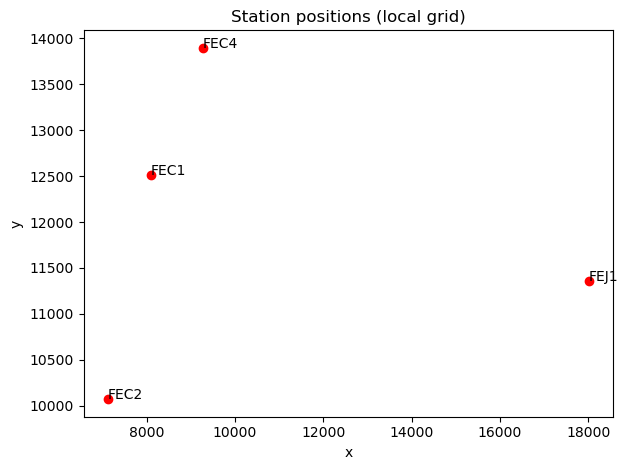

In [6]:

plt.figure()
plt.scatter(sta[:len(stations), 0], sta[:len(stations), 1], c='r')
for i, name in enumerate(stations):
    plt.text(sta[i, 0], sta[i, 1], name)
plt.title("Station positions (local grid)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()



## 7. Offset trace plot in a time window


/var/folders/y1/0ksm02_j05q2mdjsdf6j7xj80000gp/T/ipykernel_33829/2104830332.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


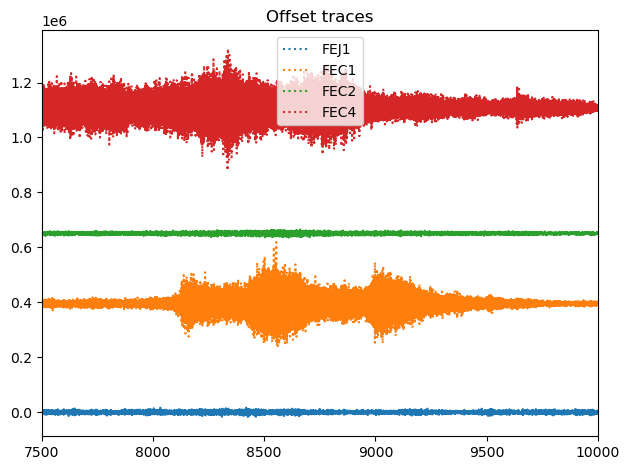

In [7]:

tvec = np.arange(maxlen) / sps
t0, t1 = (int(plot_limits_sec[0]*sps), int(plot_limits_sec[1]*sps))

plt.figure()
offset = 0.0
for i in range(len(stations)):
    series = data_env[:, i]
    if np.all(np.isnan(series)):
        continue
    seg = series[t0:t1]
    if seg.size == 0 or np.all(np.isnan(seg)):
        continue
    if i > 0:
        prev = data_env[:, i-1][t0:t1]
        prev = prev[np.isfinite(prev)]
        segf = seg[np.isfinite(seg)]
        if segf.size and prev.size:
            offset += (np.nanmax(segf) - np.nanmin(segf)) + np.nanmax(prev)
    plt.plot(tvec, offset + np.nan_to_num(series), ':', label=stations[i])

plt.xlim(plot_limits_sec)
plt.legend()
plt.title("Offset traces")
plt.tight_layout()
plt.show()



## 8. Watson fixed-slope search over candidate pixels


In [8]:

MaxR2, MaxR2x, MaxR2y, MaxR2T, Alltimes = [], [], [], [], []

rows, cols = A.shape
yy, xx = np.nonzero(A)  # candidate pixels (skip zeros in mask)
sta_x = sta[:len(stations), 0].astype(float)
sta_y = sta[:len(stations), 1].astype(float)

for ts in range(t_start_sec, t_end_sec, winlength_seconds):
    for k in range(len(xx)):
        x_src = x[xx[k]]
        y_src = y[yy[k]]
        dist = np.sqrt((x_src - sta_x) ** 2 + (y_src - sta_y) ** 2)
        if np.any(dist <= 0):
            continue

        times = dist / beta
        t1s = ((ts + times) * sps).astype(int)
        t2s = t1s + int(winlength_seconds * sps)

        ampl = np.array([window_rms(data_env[:, j], t1s[j], t2s[j]) for j in range(len(stations))], dtype=float)
        if np.any(~np.isfinite(ampl)):
            continue

        ampl_log = np.log(ampl)
        dist_log = np.log(dist)
        intercept = np.mean(ampl_log - m_slope * dist_log)

        sst = np.sum((ampl_log - ampl_log.mean())**2)
        if sst <= 0:
            continue
        ssr = np.sum((ampl_log - (intercept + m_slope * dist_log))**2)
        R2 = 1.0 - (ssr / sst)

        if R2 > 0.9:
            MaxR2.append(R2)
            MaxR2x.append(x_src)
            MaxR2y.append(y_src)
            MaxR2T.append(ts)
            Alltimes.append(ts)



## 9. Local -> UTM -> WGS84 lon/lat


In [9]:


MaxR2x = np.asarray(MaxR2x, dtype=float)
MaxR2y = np.asarray(MaxR2y, dtype=float)
StaX    = sta_x
StaY    = sta_y

# Apply fixed offsets to obtain UTM E/N
E_max = MaxR2x + UTM_E_OFFSET
N_max = MaxR2y + UTM_N_OFFSET
E_sta = StaX + UTM_E_OFFSET
N_sta = StaY + UTM_N_OFFSET

# Transform to lon/lat
Max_lon, Max_lat = TO_WGS84.transform(E_max, N_max)
Sta_lon, Sta_lat = TO_WGS84.transform(E_sta, N_sta)



## 10. Load SRTM ASCII grid

In [11]:

with gzip.open(SRTM_ASC_GZ) as fp:
    srtm = np.loadtxt(fp, skiprows=6)
lats = np.linspace(SRTM_YLL + SRTM_CELL * srtm.shape[0], SRTM_YLL, srtm.shape[0])
lons = np.linspace(SRTM_XLL, SRTM_XLL + SRTM_CELL * srtm.shape[1], srtm.shape[1])

extent = [lons.min(), lons.max(), lats.min(), lats.max()]


## 11. Plot trajectory with matplotlib

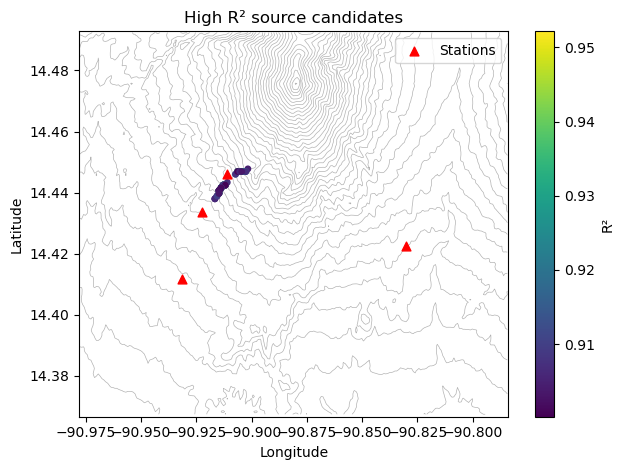

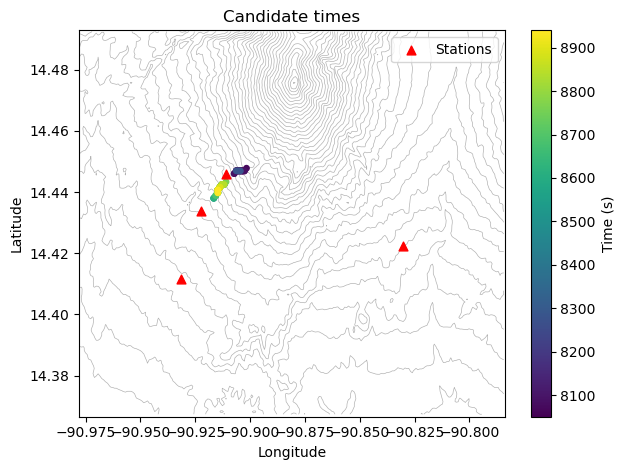

In [12]:


def deg_padding_km(pad_km: float, at_lat_deg: float):
    """Convert km padding to degrees in lon/lat at the given latitude."""
    pad_lat = pad_km / 111.0
    pad_lon = pad_km / (111.0 * np.cos(np.deg2rad(at_lat_deg)))
    return pad_lon, pad_lat

def compute_region(Sta_lon, Sta_lat, Max_lon=None, Max_lat=None, pad_km=5.0):
    # Combine all lon/lat points we want in view
    lons = np.array(Sta_lon, dtype=float)
    lats = np.array(Sta_lat, dtype=float)
    if Max_lon is not None and len(Max_lon):
        lons = np.r_[lons, np.asarray(Max_lon, dtype=float)]
        lats = np.r_[lats, np.asarray(Max_lat, dtype=float)]
    lon0, lon1 = np.nanmin(lons), np.nanmax(lons)
    lat0, lat1 = np.nanmin(lats), np.nanmax(lats)
    midlat = 0.5*(lat0+lat1)
    dlon, dlat = deg_padding_km(pad_km, midlat)
    return [lon0 - dlon, lon1 + dlon, lat0 - dlat, lat1 + dlat]  # [xmin,xmax,ymin,ymax]

def subset_grid(lons_1d, lats_1d, grid_2d, region):
    """Return sliced (lons, lats, grid) within region = [xmin, xmax, ymin, ymax]."""
    xmin, xmax, ymin, ymax = region
    # Ensure lats are descending (SRTM ASCII often is)
    lats = lats_1d
    Z = grid_2d
    if lats[0] < lats[-1]:
        lats = lats[::-1]
        Z = Z[::-1, :]

    lon_mask = (lons_1d >= xmin) & (lons_1d <= xmax)
    lat_mask = (lats      >= ymin) & (lats      <= ymax)

    lons_sub = lons_1d[lon_mask]
    lats_sub = lats[lat_mask]
    Z_sub    = Z[np.ix_(lat_mask, lon_mask)]
    Lon_sub, Lat_sub = np.meshgrid(lons_sub, lats_sub)
    return Lon_sub, Lat_sub, Z_sub

# --- Build a zoomed region around stations and candidates (5 km pad) ---
region = compute_region(Sta_lon, Sta_lat, Max_lon, Max_lat, pad_km=5.0)

# --- Subset the SRTM grid to that region for fast, clean contours ---
Lon_sub, Lat_sub, Z_sub = subset_grid(lons, lats, srtm, region)

# ===== Plot 1: colored by R² =====
plt.figure()
plt.contour(Lon_sub, Lat_sub, Z_sub, levels=40, colors="k", alpha=0.3, linewidths=0.5)
sc = plt.scatter(Max_lon, Max_lat, c=MaxR2, s=15, cmap='viridis', zorder=3)
plt.colorbar(sc, label="R²")
plt.scatter(Sta_lon, Sta_lat, c='r', marker='^', s=40, label='Stations', zorder=4)
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("High R² source candidates")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ===== Plot 2: colored by time =====
plt.figure()
plt.contour(Lon_sub, Lat_sub, Z_sub, levels=40, colors="k", alpha=0.3, linewidths=0.5)
sc = plt.scatter(Max_lon, Max_lat, c=Alltimes, s=15, cmap='viridis', zorder=3)
plt.colorbar(sc, label="Time (s)")
plt.scatter(Sta_lon, Sta_lat, c='r', marker='^', s=40, label='Stations', zorder=4)
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Candidate times")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## 12. Plot trajectory with pyGMT

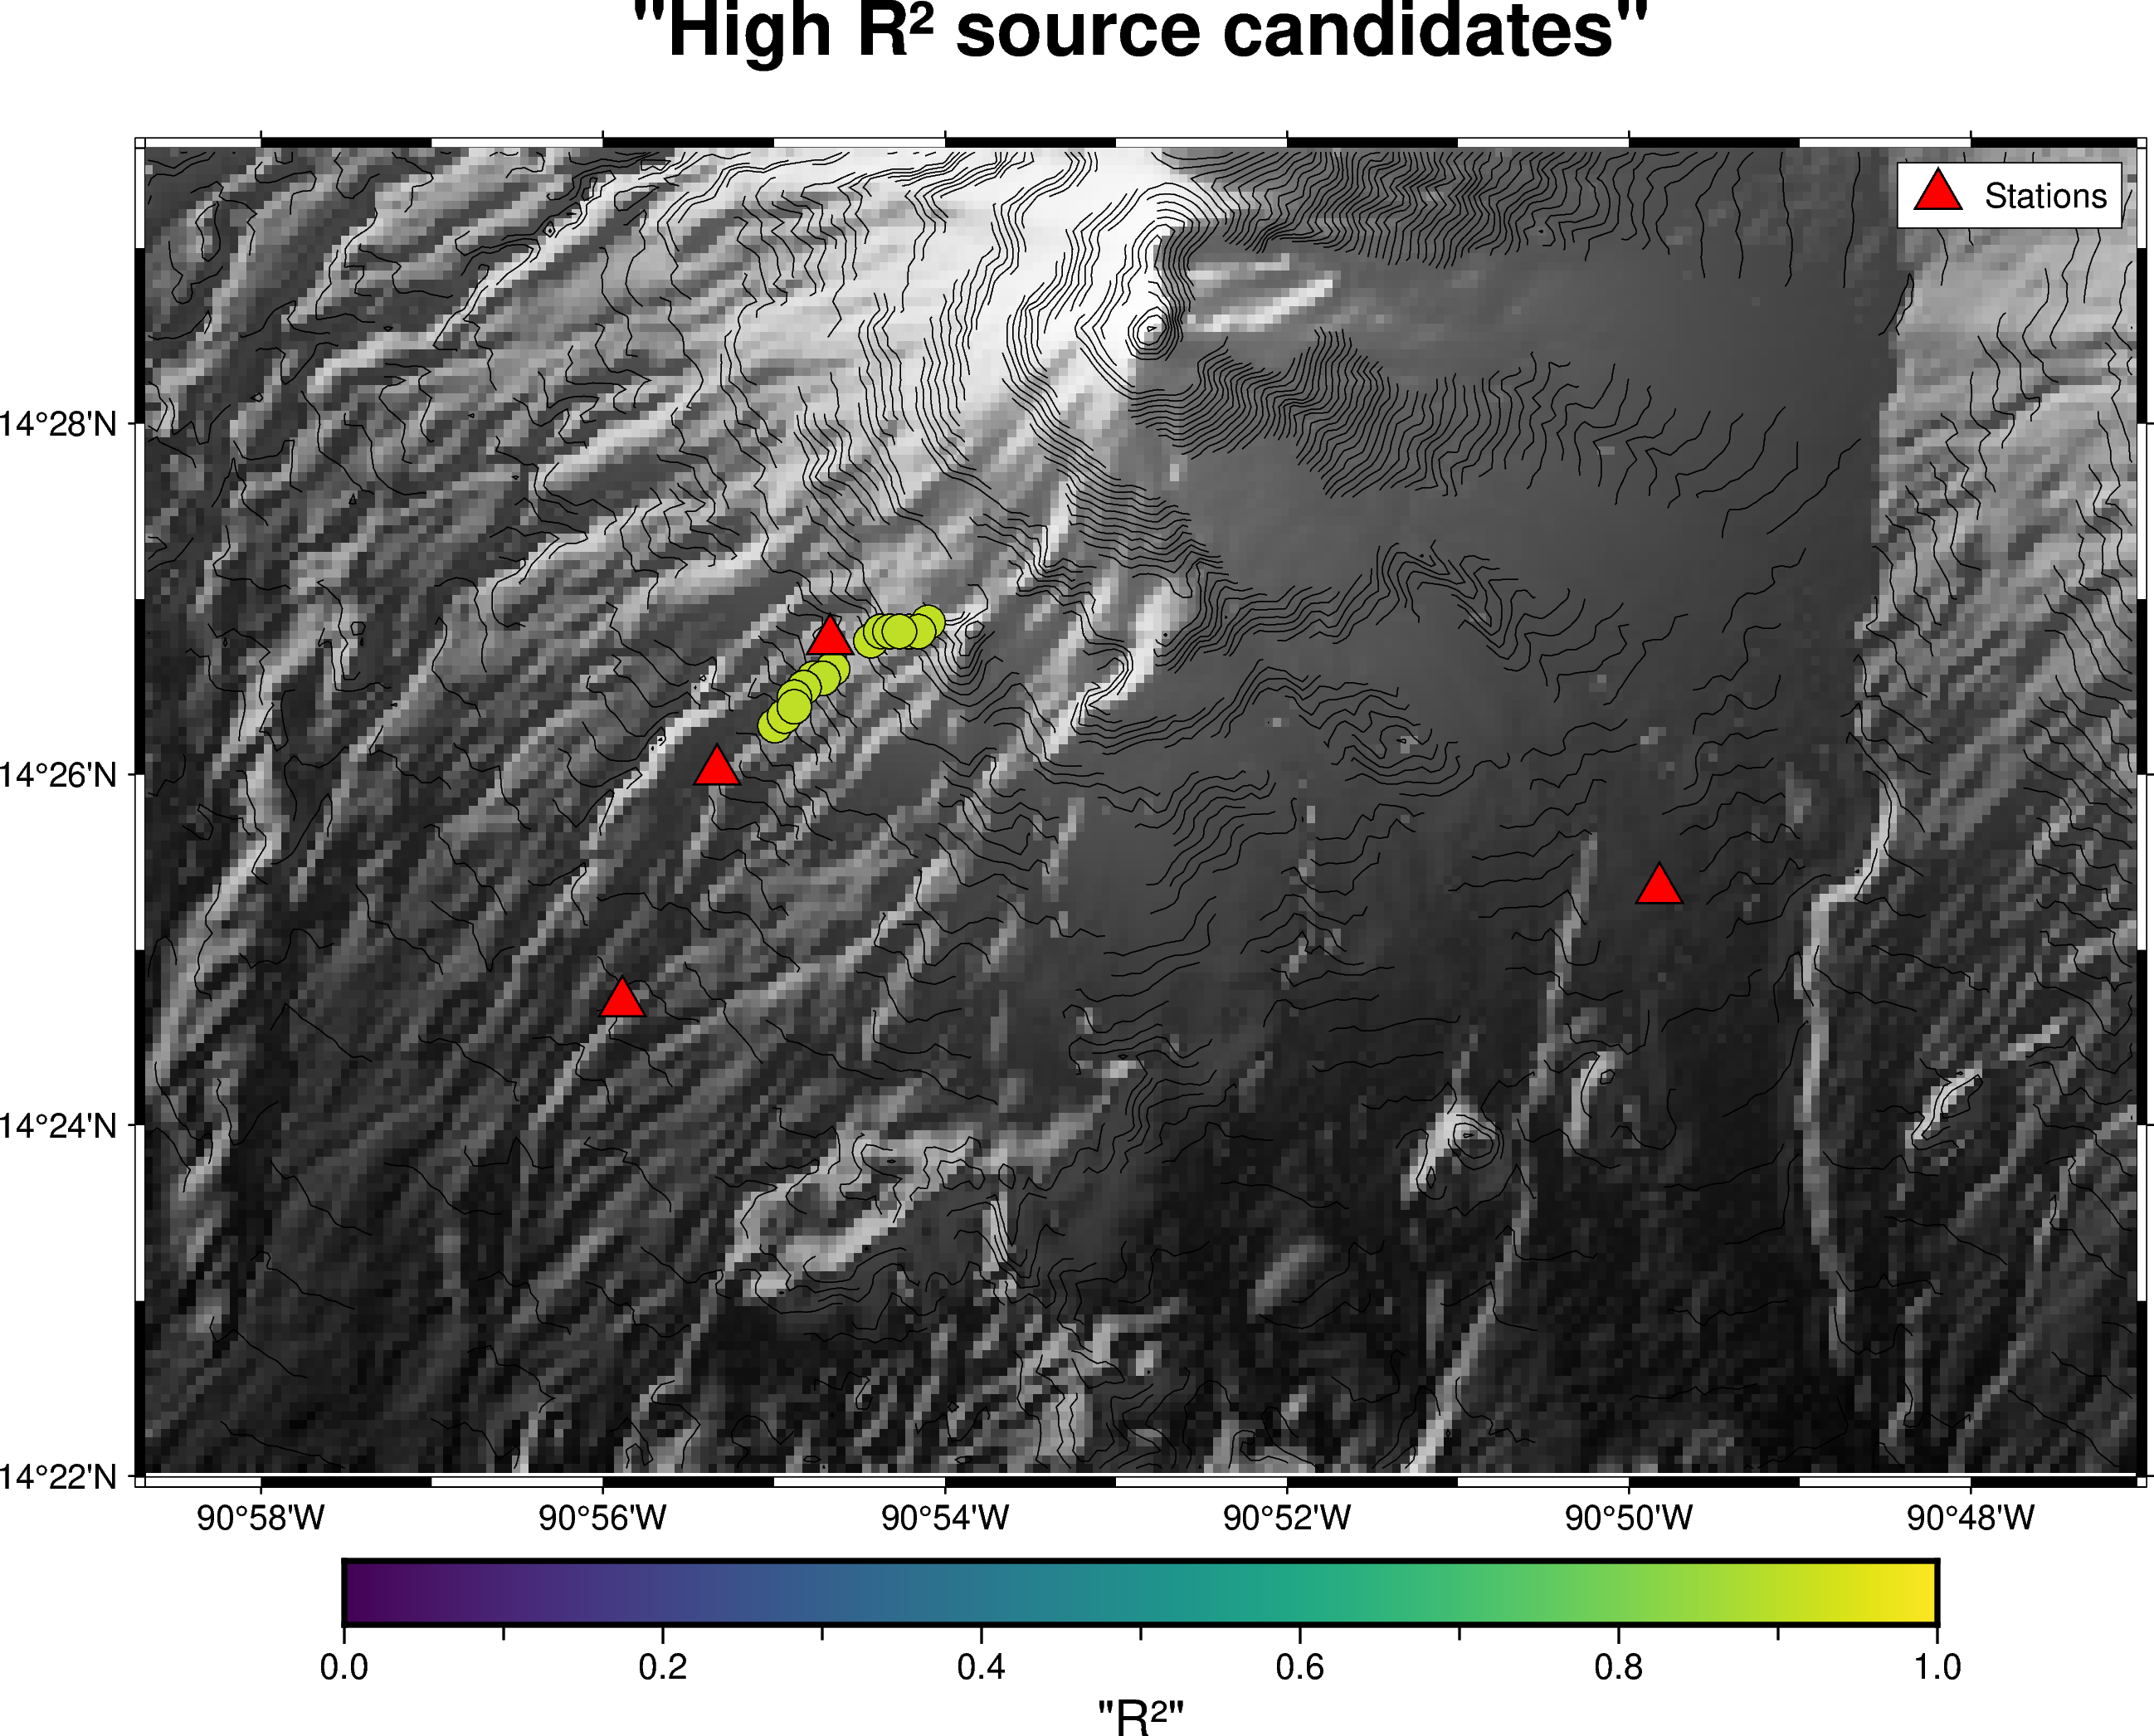

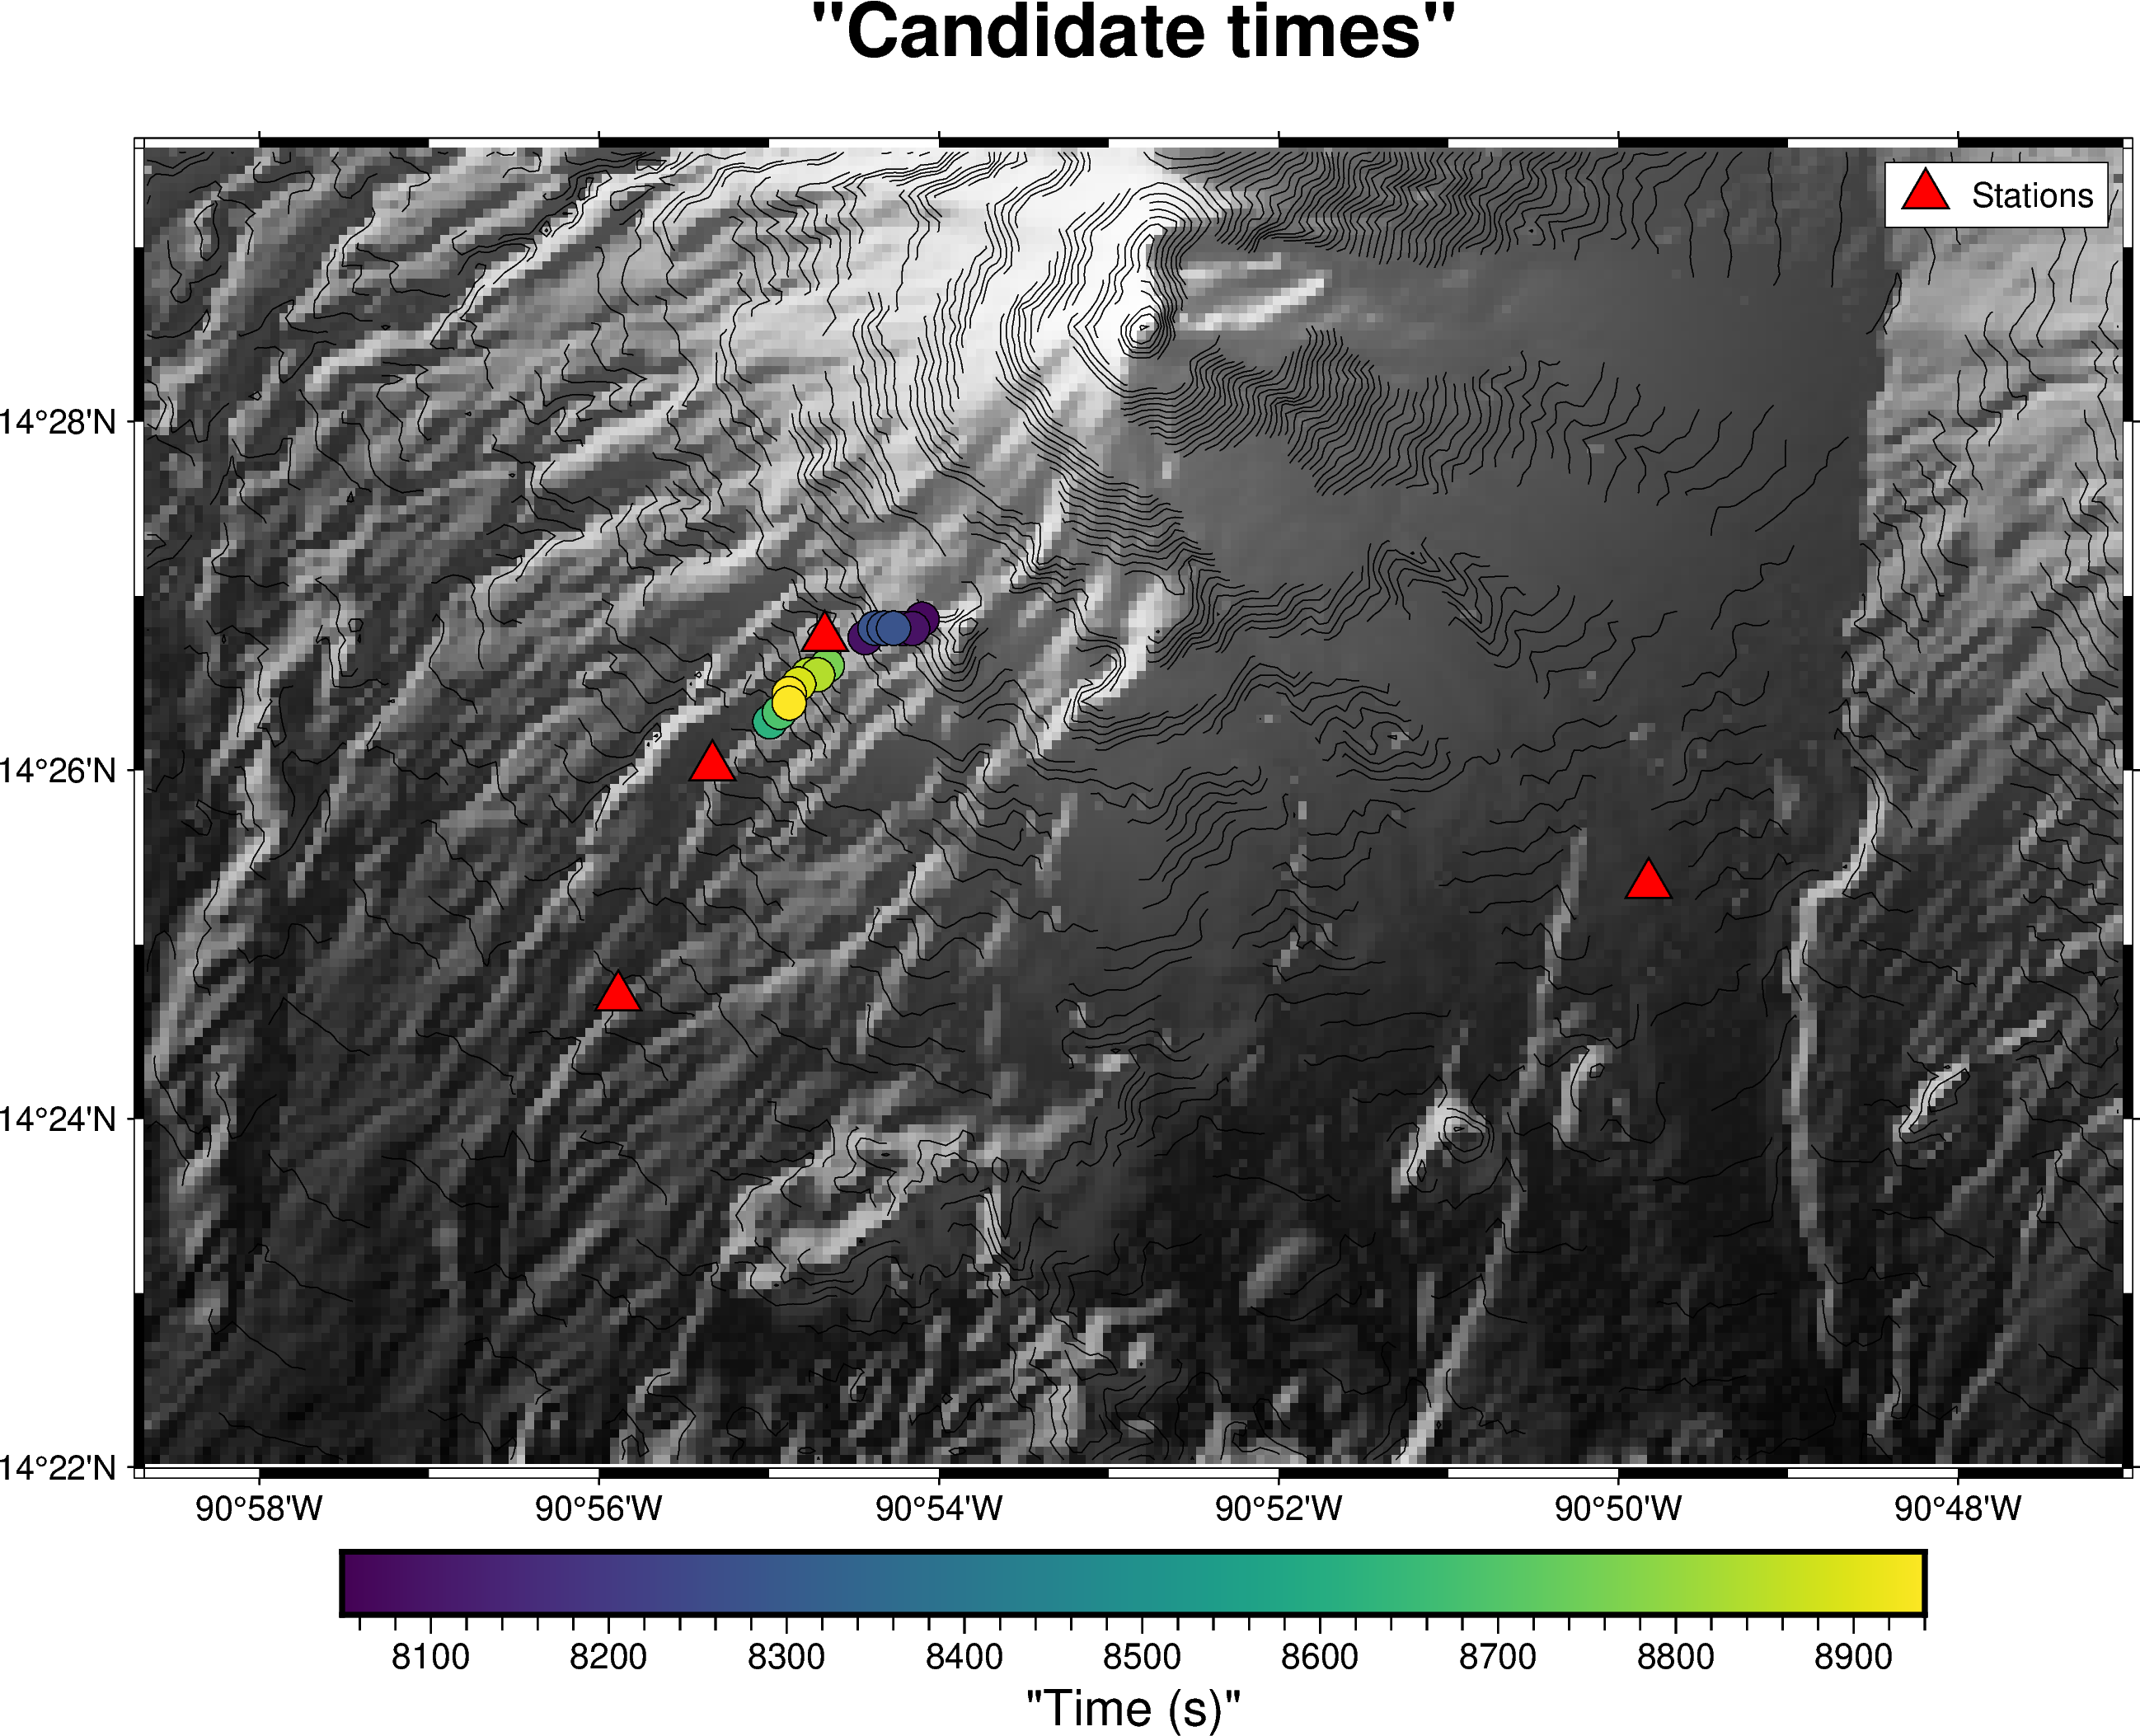

In [15]:


# --- helpers ---
def deg_padding_km(pad_km: float, at_lat_deg: float):
    pad_lat = pad_km / 111.0
    pad_lon = pad_km / (111.0 * np.cos(np.deg2rad(at_lat_deg)))
    return pad_lon, pad_lat

def compute_region(Sta_lon, Sta_lat, Max_lon=None, Max_lat=None, pad_km=5.0):
    lons = np.asarray(Sta_lon, dtype=float)
    lats = np.asarray(Sta_lat, dtype=float)
    if Max_lon is not None and len(Max_lon):
        lons = np.r_[lons, np.asarray(Max_lon, dtype=float)]
        lats = np.r_[lats, np.asarray(Max_lat, dtype=float)]
    lon0, lon1 = np.nanmin(lons), np.nanmax(lons)
    lat0, lat1 = np.nanmin(lats), np.nanmax(lats)
    midlat = 0.5*(lat0+lat1)
    dlon, dlat = deg_padding_km(pad_km, midlat)
    return [lon0 - dlon, lon1 + dlon, lat0 - dlat, lat1 + dlat]

def subset_grid(lons_1d, lats_1d, grid_2d, region):
    xmin, xmax, ymin, ymax = region
    Z = grid_2d
    lats = lats_1d
    if lats[0] > lats[-1]:   # ensure ascending
        lats = lats[::-1]
        Z = Z[::-1, :]
    lon_mask = (lons_1d >= xmin) & (lons_1d <= xmax)
    lat_mask = (lats      >= ymin) & (lats      <= ymax)
    lons_sub = lons_1d[lon_mask]
    lats_sub = lats[lat_mask]
    Z_sub    = Z[np.ix_(lat_mask, lon_mask)]
    dem = xr.DataArray(
        Z_sub,
        coords={"lat": lats_sub, "lon": lons_sub},
        dims=("lat", "lon"),
        name="elevation",
    )
    return dem

# --- zoom region + DEM subset ---
region = compute_region(Sta_lon, Sta_lat, Max_lon, Max_lat, pad_km=5.0)
dem = subset_grid(lons, lats, srtm, region)

# Bigger map
projection = "M8i"  # 12-inch wide map

# Symbol sizes
cand_sym = "c0.35c"  # candidate circles (diameter)
sta_sym  = "t0.55c"  # station triangles (side length)

# --- Plot colored by R² ---
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame=["af", '+t"High R² source candidates"'])

# Background as contours (use levels/pen/fill per your PyGMT version)
fig.grdimage(dem, cmap="gray", shading=True)  # nice base
fig.grdcontour(dem, levels=40, pen="0.25p,black,40%")  # faint contour overlay (optional)

# Candidate points: bigger circles, outlined lightly
pygmt.makecpt(cmap="viridis")
fig.plot(x=Max_lon, y=Max_lat, style=cand_sym, fill=MaxR2, cmap=True, pen="0.25p,black")
fig.colorbar(frame='af+l"R²"')

# Stations: larger triangles, red fill, black outline
fig.plot(x=Sta_lon, y=Sta_lat, style=sta_sym, fill="red", pen="0.5p,black", label="Stations")
fig.legend(position="JTR+jTR+o0.15c", box="+gwhite+p0.25p")

# Save high-DPI and show
fig.savefig("candidates_R2.png", dpi=300)
fig.show()

# --- Plot colored by time ---
fig = pygmt.Figure()
fig.basemap(region=region, projection=projection, frame=["af", '+t"Candidate times"'])
fig.grdimage(dem, cmap="gray", shading=True)  # nice base
fig.grdcontour(dem, levels=40, pen="0.25p,black,40%")  # faint contour overlay (optional)

# Make a CPT spanning the values in Alltimes
pygmt.makecpt(cmap="viridis", series=[min(Alltimes), max(Alltimes)])
fig.plot(x=Max_lon, y=Max_lat, style=cand_sym, fill=Alltimes, cmap=True, pen="0.25p,black")
fig.plot(x=Max_lon, y=Max_lat, style=cand_sym, fill=Alltimes, cmap=True, pen="0.25p,black")
fig.colorbar(frame='af+l"Time (s)"')

fig.plot(x=Sta_lon, y=Sta_lat, style=sta_sym, fill="red", pen="0.5p,black", label="Stations")
fig.legend(position="JTR+jTR+o0.15c", box="+gwhite+p0.25p")

fig.savefig("candidates_time.png", dpi=300)
fig.show()